# Ames Housing OLS Regression Project
#### Alan Kessler, Predict 410 Section 57

This notebook contains the code accompanying the report. The following modules are used in the analysis.

StatsModels is used inplace of scikit-learn due to its more robust offering of statistical diagnostics for regression. Scikit-learn is still used to standardize residuals. 

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import scipy.stats
import statsmodels.api as sm
from sklearn import preprocessing
pd.set_option('display.max_rows', 100) 

## First Steps

### Load Data

The variable **index** will be treated as the dataframe index column. For the test data, **p_saleprice** and **SalePrice1** are dropped so that it can be processed identically to the training set prior to scoring.

In [2]:
# Load training data
train = pd.read_csv('AMES_TRAIN.csv', index_col=-1)
# Load testing data - index is in different column
test = pd.read_csv('AMES_TEST_SFAM.csv', index_col=0)
# Drop the blank columns corresponding to the target variables
test.drop(['p_saleprice', 'SalePrice'], axis=1, inplace=True)

### A Data Survey

Based in large part on the provided code.

In [3]:
# Provides general information about the data set
des = {'train': ['Object Type', 'Number of observations', 
                 'Number of columns'],
         'Output': [type(train), len(train), 
                    train.shape[1]]}
display(pd.DataFrame.from_dict(des).set_index('train'))

print("Variable names:")
print(train.columns.tolist())

# Provide a preview of the data
display(train.head())

,Output
train,
Object Type,<class 'pandas.core.frame.DataFrame'>
Number of observations,2039
Number of columns,80


Variable names:
['SubClass', 'Zoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodel', 'RoofStyle', 'RoofMat', 'Exterior1', 'Exterior2', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea',

,SubClass,Zoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
index,,,,,,,,,,,,,,,,,,,,,
2,20,RL,NaN,11838,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,236500
3,60,RL,70.0,8304,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,7,2006,WD,Normal,187000
5,45,RM,58.0,6380,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2006,WD,Normal,113000
6,60,RL,NaN,14803,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,GdWo,NaN,0,6,2006,WD,Normal,190000
8,20,RL,91.0,11375,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,WD,Normal,150000


### Define the Sample Population

The test set is entirely made up of single-family homes. Using summary statistics to determine at a glance how helpful other building types can be in predicting single-family home prices.

In [4]:
# Summary statistics by BldgType
btypes = train[['BldgType', 'SalePrice']].groupby('BldgType').agg([len, np.mean])
btypes.columns = btypes.columns.droplevel()
btypes['Percent'] = btypes['len'] / sum(btypes['len'])
btypes.columns = ['Count', 'Avg SalePrice', 'Percent']
btypes = btypes[['Count', 'Percent', 'Avg SalePrice']].sort_values(by=['Count'], ascending=False)
btypes.style.format({
    'Count': '{:,.0f}'.format,
    'Percent': '{:,.2%}'.format,
    'Avg SalePrice': '{:,.0f}'.format,
})

As decribed in the report, other types are excluded for these simple models.

In [5]:
# Filter out all but single family homes in training to match test
train_sfam = train.copy()[train['BldgType'] == "1Fam"]

# Drop the column from both training and testing sets
train_sfam.drop(['BldgType'], axis=1, inplace=True)
test.drop(['BldgType'], axis=1, inplace=True)

### Data Quality Checks
#### Target Variable

Check for unintuitive values of SalePrice such as negatives.

In [6]:
train_sfam[['SalePrice']].describe().style.format({'SalePrice': '{:,.0f}'.format})

Box plot of **SalePrice**

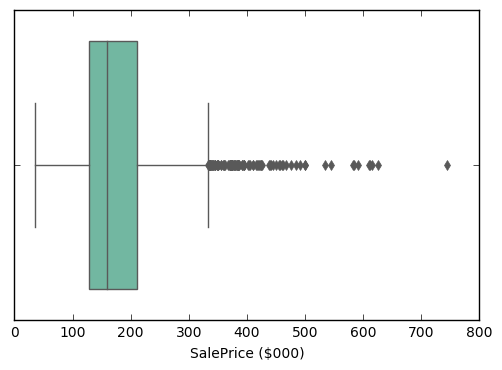

In [7]:
bplot1 = sns.boxplot(x=train['SalePrice'], palette='Set2')
ticks = bplot1.get_xticks()
bplot1.set_xticklabels(['{:,.0f}'.format(x/1000) for x in ticks])
bplot1.set(xlabel='SalePrice ($000)')
plt.show()

Remove the maximum SalePrice value which appears to be an outlier.

In [8]:
train_sfam.drop(train_sfam['SalePrice'].idxmax(), axis=0, inplace=True)

#### Predictors

The data has multiple types of variables. For this analysis, they are divided into three categories:
- Numerical/Interval variables - Continuous or discrete variables related to distances or areas
- Time variables - Variables in years
- Nominal/Categorical variables - Variables with categories or continues/discrete variables with few unique values observed

In [9]:
# Columns treated as interval/continuous/discrete/ordinal variables
intVars = ['MiscVal', 'PoolArea', 'ScreenPorch',
           'ThreeSsnPorch', 'EnclosedPorch', 'OpenPorchSF',
           'WoodDeckSF', 'GarageArea', 'LotArea',
           'GrLivArea', 'LowQualFinSF', 'FirstFlrSF',
           'SecondFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
           'BsmtFinSF2', 'BsmtFinSF1', 'MasVnrArea',
           'LotFrontage', 'SalePrice']

# Columns related to time
yearVars = ['YearBuilt', 'YearRemodel', 'GarageYrBlt']

# Columns treated as categorical variables
# Includes ordinal and low cardinality interval/discrete/ordinal
nomVars = np.setdiff1d(train_sfam.columns, intVars+yearVars).tolist()

**Continuous Variables**

Check continuous variables for missing values.

In [10]:
# Get missing rate for the interval variables with at least one missing
train_int_na = train_sfam[intVars].isnull().sum() / len(train_sfam)
train_int_na = pd.DataFrame(train_int_na.drop(train_int_na[train_int_na == 0].index)).sort_values(by=[0], ascending=False)
train_int_na.columns = ["Missing Rate"]
train_int_na.style.format({'Missing Rate': '{:.2%}'.format})

In [11]:
# Check that the testing set has similar missing columns for function
test_int_na = test[intVars[:-1]].isnull().sum() / len(test)
test_int_na = pd.DataFrame(test_int_na.drop(test_int_na[test_int_na == 0].index)).sort_values(by=[0], ascending=False)
test_int_na.columns = ["Missing Rate"]
test_int_na.style.format({'Missing Rate': '{:.2%}'.format})

If **LotFrontage** is missing, replace by with the training data median. If a variable is an area measure, it is likely because the home does not have that feature, so a zero would be imputed.

In [12]:
# Process missing variables
def process_miss_int(df):
    adj = df.copy()
    for column in intVars[:-1]:
        if column == 'LotFrontage':
            adj[column].fillna(train_sfam[column].median(), inplace=True)
        else:
            adj[column].fillna(0, inplace=True)
    return adj

train_miss1 = process_miss_int(train_sfam)
test_miss1 = process_miss_int(test)

Examine summary statistics

In [13]:
train_sfam[intVars[:-1]].describe().transpose().drop(['count'], axis=1).style.format("{:.0f}")

For a simple model with only one to two predictors, each variable needs to successfully segment the data well by sale price. If a large majority of observations have the same value for a variable, it is likely not as useful. This results in the following continuous variable warranting further exploratory data analysis: 

- **LotArea**
- **GrLivArea**
- **TotalBsmtSF**
- **LotFrontage**

These variables also have an intuitive relationship to home price as larger homes and lots likely cost more.

**Variables related to time**

Examine summary statistics

In [14]:
train_miss1[yearVars].describe().transpose().drop(['count'], axis=1).style.format("{:.0f}")

Check for missing values in time variables

In [15]:
train_t_na = train_miss1[yearVars].isnull().sum() / len(train_miss1)
train_t_na = pd.DataFrame(train_t_na).sort_values(by=[0], ascending=False)
train_t_na.columns = ["Missing Rate"]
train_t_na.style.format({'Missing Rate': '{:.2%}'.format})

If garage year built is missing, the home can be assumed not to have a garage. The summary statistics also identified a possible error in one of the entries.

In [16]:
# Process missing value for garage as 1850 for possible plotting purposes
# Entry of 2207 assumed to be a typo for 2007
def process_gyr(df):
    adj = df.copy()
    adj["GarageYrBlt"].fillna(0, inplace=True)
    adj.GarageYrBlt.replace({2207:2007}, inplace=True)
    return adj

train_miss2 = process_gyr(train_miss1)
test_miss2 = process_gyr(test_miss1)

The remodel year data does not have any information prior to 1950, and the garage year built won't have results if the property does not have a garage. For a simple model, I am most interested in exploring **YearBuilt** further in EDA.

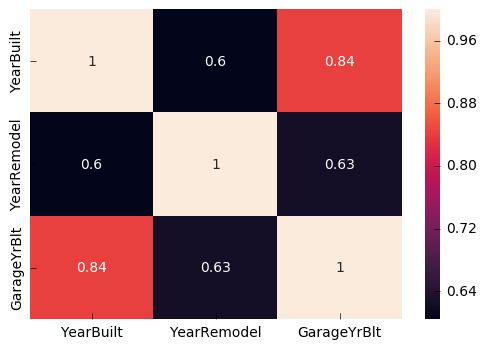

In [17]:
# Corrleation excluding the observations missing a garage
corr = train_miss2[yearVars][train_miss2['GarageYrBlt'] > 0].corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

The year-related variables are also correlated so choosing one to investigate further will reduce the risk of multicollinearity.

**Categorical Variables**

Get missing rate for the nominal variables with at least one missing.

In [18]:
train_nom_na = train_miss2[nomVars].isnull().sum() / len(train_miss2)
train_nom_na = pd.DataFrame(train_nom_na.drop(train_nom_na[train_nom_na == 0].index)).sort_values(by=[0], ascending=False)
train_nom_na.columns = ["Missing Rate"]
train_nom_na.style.format({'Missing Rate': '{:.2%}'.format})

Impute the missing values with zero if missing indicates that the property does not have that feature and the mode level otherwise. 

In [19]:
# Variables that should be imputed with blanks
toBlank = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
          'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
          'BsmtQual', 'GarageCond', 'GarageFinish', 'GarageQual',
          'Fence', 'FireplaceQu', 'GarageType', 'MiscFeature', 
          'PoolQC']

# Impute missing depending on the column either mode of training or blank
def process_miss_nom(df):
    adj = df.copy()
    for column in nomVars:
        if column in toBlank:
            adj[column].fillna("Blank", inplace=True)
        else:
            adj[column].fillna(train_miss2[column].mode()[0], inplace=True)
    return adj

train_miss3 = process_miss_nom(train_miss2)
test_miss3 = process_miss_nom(test_miss2)

Check that the training data does not contain levels not in the data dictionary.

**Produces a large amount of output so collapse the output cell of the notebook.**

In [20]:
# Plot one-way table
def one_way_table(df, var):
    df = df[[var, 'SalePrice']].groupby(var).agg([len, np.mean, np.std])
    df.columns = df.columns.droplevel()
    df['Percent'] = np.round(df['len'] / sum(df['len']), 4)
    df['Avg SalePrice'] = np.round(df['mean'], 2)
    df.columns = ['Count', 'mean', 'Std Dev SalePrice', 'Percent', 'Avg SalePrice']
    tbldf = df[['Count', 'Percent', 'Avg SalePrice', 'Std Dev SalePrice']].sort_values(by=['Count'], ascending=False)
    display(tbldf.style.format({'Count': '{:,.0f}'.format,
                           'Percent': '{:,.2%}'.format,
                           'Avg SalePrice': '{:,.0f}'.format,
                           'Std Dev SalePrice': '{:,.0f}'.format}))

# Code used to check for allowed values in the training data
for var in nomVars:
    one_way_table(train_miss3, var)

Variables to be investigated further in EDA need to demonstrate strong segmentation in the target and have observations spread across levels rather than a single category. The resulting categorical variables warranting further analysis are:
- **BedroomAbvGr**
- **OverallQual**
- **Neighborhood**
- **KitchenQual**
- **GarageCars**

Homes with larger garages and more rooms in nicer neighborhoods likely cost more, so there is an intuitive relationship between the variables as well.

## Exploratory Data Analysis

### Categorical Variables

Create a way to view a one-way analysis with understanding the sample size for each categorical level. This is a common actuarial approach which can be found on page 190 (labelled page 178) of the linked PDF below.

[Werner, G, and Modlin, C., Basic Ratemaking, Casualty Actuarial Society, Fifth Edition, May 2016.](http://www.casact.org/library/studynotes/Werner_Modlin_Ratemaking.pdf)

In [21]:
def category_plot(df, var, 
                  ci=True, width=6.5, height=4, 
                  alpha=0.2, legend_loc='upper right'):
    
    # Create data for plot
    df = df[[var, 'SalePrice']].groupby(var).agg([len, np.mean, np.std])
    df.columns = df.columns.droplevel()
    df.columns = ['count', 'mean', 'std']
    plotdf = df.reset_index()

    # Create figure with size properties
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)

    # Row count axis
    sns.barplot(x=var, y='count', data=plotdf, ax=ax, color='dodgerblue', label='Count')
    y1ticks = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in y1ticks])
    ax.set(ylabel='Row Count')

    # Point axis 
    ax2 = ax.twinx()
    sns.pointplot(x=var, y='mean', data=plotdf, ax=ax2, color='black')

    # Legend for the first axis
    lines, labels = ax.get_legend_handles_labels()

    # Add confidence intervals if requested
    if ci:
        z = scipy.stats.norm(0, 1).isf(alpha/2)
        plotdf['lowerCI'] = plotdf['mean'] - z*plotdf['std']/np.sqrt(plotdf['count'])
        sns.pointplot(x=var, y='lowerCI', data=plotdf, ax=ax2, color='slategray')
        plotdf['upperCI'] = plotdf['mean'] + z*plotdf['std']/np.sqrt(plotdf['count'])
        sns.pointplot(x=var, y='upperCI', data=plotdf, ax=ax2, color='slategray')
        ax2.legend(handles=lines + ax2.lines[::len(plotdf)+1], 
                   labels = labels + ["Avg SalePrice", str(100*(1-alpha)) + "% CI"], 
                   prop={'size': 9}, loc=legend_loc)
    else:
        ax2.legend(handles=lines + ax2.lines[:], 
                   labels = labels + ["Avg SalePrice"], 
                   prop={'size': 9}, loc=legend_loc)

    # Modify second axis units
    y2ticks = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0f}'.format(x/1000) for x in y2ticks])
    ax2.set(ylabel='SalePrice ($000)')

    plt.show()

**BedroomAbvGr**

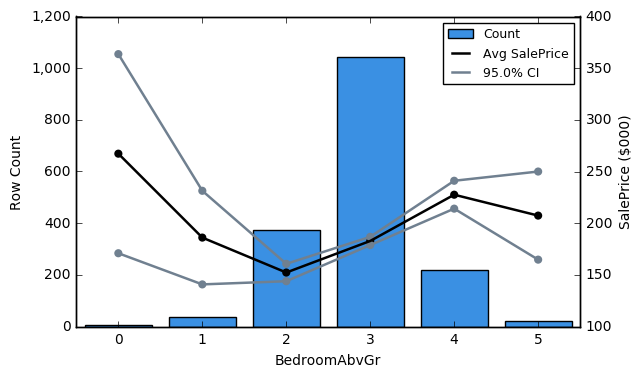

In [22]:
category_plot(train_miss3, var = 'BedroomAbvGr', alpha=0.05)

Low sample size and unintuitive one-way results, indicate that grouping is needed. The relationship with SalePrice is strong for the three most populated levels.

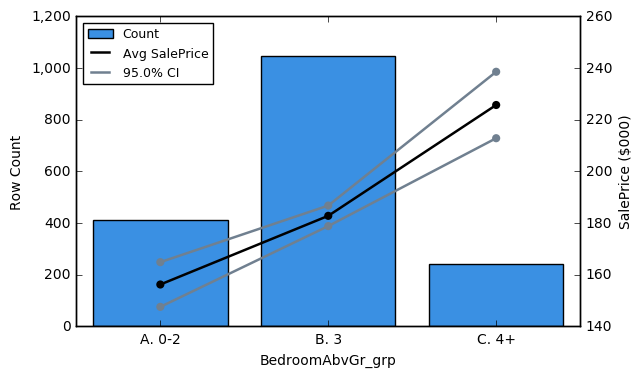

In [23]:
def grp_BAG(row):
    if row['BedroomAbvGr'] <= 2:
        return "A. 0-2"
    elif row['BedroomAbvGr'] == 3:
        return "B. 3"
    else:
        return "C. 4+"

train_miss3['BedroomAbvGr_grp'] = train_miss3.apply(grp_BAG, axis=1)
test_miss3['BedroomAbvGr_grp'] = test_miss3.apply(grp_BAG, axis=1)

category_plot(train_miss3, var = 'BedroomAbvGr_grp', alpha=0.05, legend_loc='upper left')

**OverallQual**

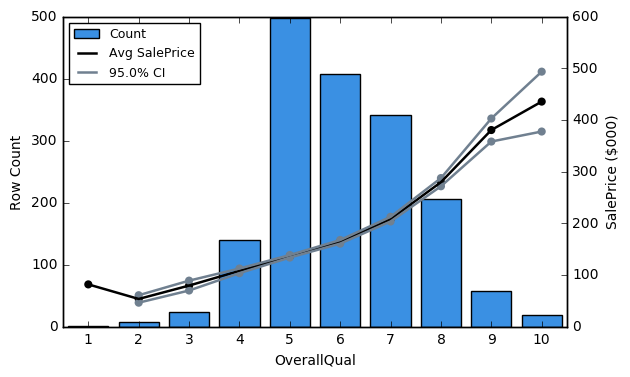

In [24]:
category_plot(train_miss3, var = 'OverallQual', alpha=0.05, legend_loc='upper left')

OverallQual appears very correlated with SalePrice. The only adjustment to make would be to group level 1 with level 2.

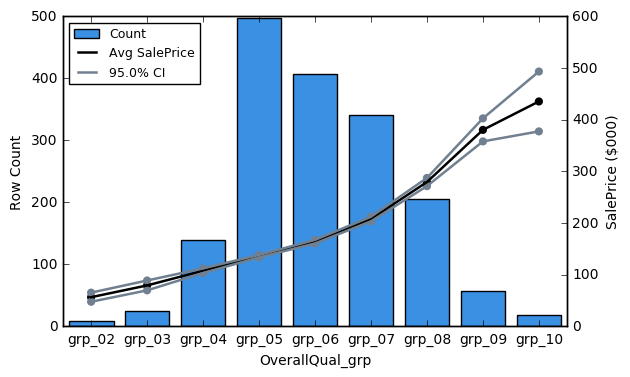

In [25]:
def grp_OQ(row):
    if row['OverallQual'] == 1:
        return "grp_02"
    else:
        return "grp_" + str(row['OverallQual']).zfill(2) 

train_miss3['OverallQual_grp'] = train_miss3.apply(grp_OQ, axis=1)
test_miss3['OverallQual_grp'] = test_miss3.apply(grp_OQ, axis=1)

category_plot(train_miss3, var = 'OverallQual_grp', alpha=0.05, legend_loc='upper left')

**Neighborhood**

There are too many levels of Neighborhood to look at visually, so a table is used instead.

In [26]:
# Plot one-way table
one_way_table(train_miss3, var='Neighborhood')

Neighborhood shows clear segmentation making it a strong candidate for a model variable. As a practice, levels under 2% of training data are grouped with similar levels from the one-way analysis.

In [27]:
def grp_N(row):
    row['Neighborhood'] = str(row['Neighborhood']).strip()
    if row['Neighborhood'] in ["NWAmes", "Blmngtn"]:
        return "NWAmes and Blmngtn"
    elif row['Neighborhood'] in ["Timber", "Veenker"]:
        return "Timber and Veenker"
    elif row['Neighborhood'] in ["NridgHt", "StoneBr"]:
        return "NridgHt and StoneBr"
    elif row['Neighborhood'] in ["Sawyer", "SWISU"]:
        return "Sawyer and SWISU"
    elif row['Neighborhood'] in ["Crawfor", "ClearCr"]:
        return "Crawfor and ClearCr"
    else:
        return row['Neighborhood']

train_miss3['Neighborhood_grp'] = train_miss3.apply(grp_N, axis=1)
test_miss3['Neighborhood_grp'] = test_miss3.apply(grp_N, axis=1)

one_way_table(train_miss3, var='Neighborhood_grp')

**KitchenQual**

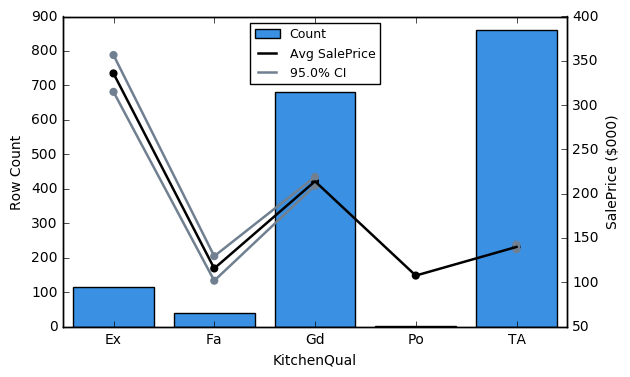

In [28]:
category_plot(train_miss3, var = 'KitchenQual', alpha=0.05, legend_loc='upper center')

KitchenQual shows strong segmentation with SalePrice. Fa is grouped with Po due to similar results and intuitive relationship. The levels are ordered to reflect ordinal nature.

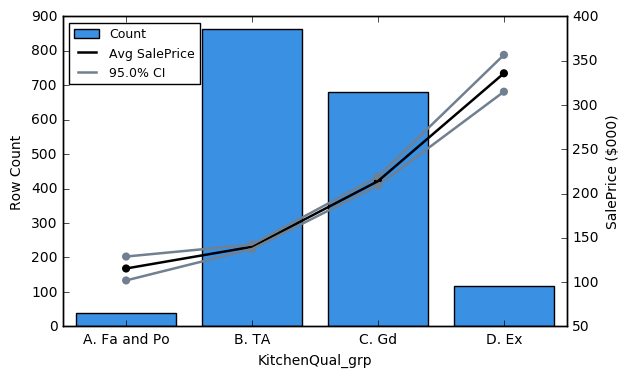

In [29]:
def grp_KQ(row):
    row['KitchenQual'] = str(row['KitchenQual']).strip()
    if row['KitchenQual'] in ["Ex"]:
        return "D. Ex"
    elif row['KitchenQual'] in ["Gd"]:
        return "C. Gd"
    elif row['KitchenQual'] in ["Fa", "Po"]:
        return "A. Fa and Po"
    else:
        return "B. TA"

train_miss3['KitchenQual_grp'] = train_miss3.apply(grp_KQ, axis=1)
test_miss3['KitchenQual_grp'] = test_miss3.apply(grp_KQ, axis=1)

category_plot(train_miss3, var = 'KitchenQual_grp', alpha=0.05, legend_loc='upper left')

**GarageCars**

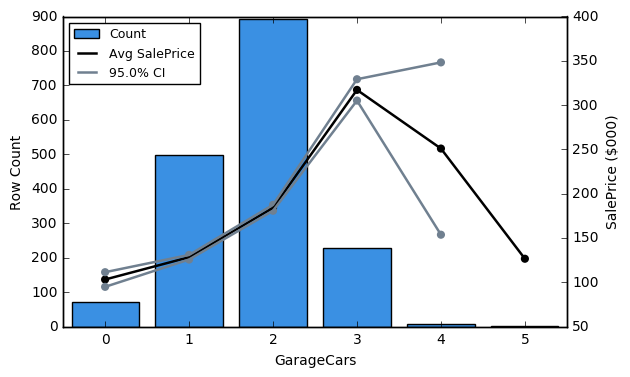

In [30]:
category_plot(train_miss3, var = 'GarageCars', alpha=0.05, legend_loc='upper left')

The intuitive relationship between more garage spots and higher SalePrice holds however, larger groups should be grouped together due to low credibility.

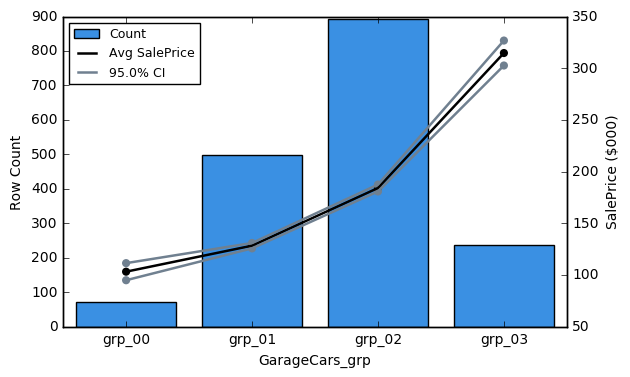

In [31]:
def grp_GC(row):
    if row['GarageCars'] >= 3:
        return "grp_03"
    else:
        return "grp_" + str(row['GarageCars']).zfill(2)

train_miss3['GarageCars_grp'] = train_miss3.apply(grp_GC, axis=1)
test_miss3['GarageCars_grp'] = test_miss3.apply(grp_GC, axis=1)

category_plot(train_miss3, var = 'GarageCars_grp', alpha=0.05, legend_loc='upper left')

### Continuous Variables

**YearBuilt**

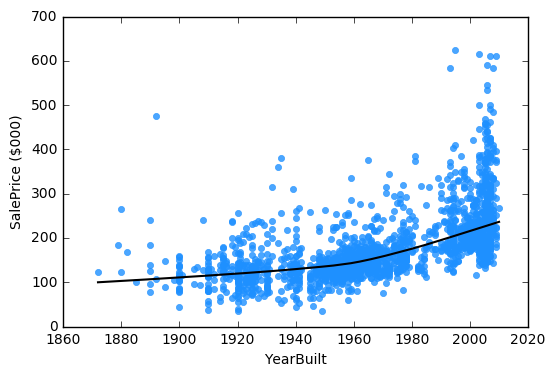

In [32]:
sc = sns.regplot(x="YearBuilt", y="SalePrice", 
                 data=train_miss3, lowess=True,
                 color="dodgerblue", line_kws={'color': 'black'})
ticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ticks])
sc.set(ylabel='SalePrice ($000)')
plt.show()

There does not seem to be as strong of a relationship between YearBuilt and SalePrice prior to 1950. This results in the LOESS smooth-line not being linear. Because YearRemodel caps at 1950, it will be used instead.

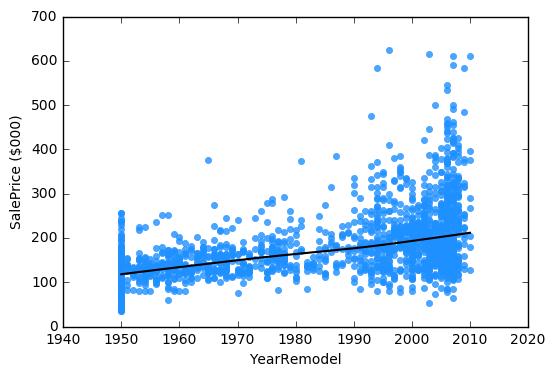

In [33]:
sc = sns.regplot(x="YearRemodel", y="SalePrice", 
                 data=train_miss3, lowess=True, 
                 color="dodgerblue", line_kws={'color': 'black'})
ticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ticks])
sc.set(ylabel="SalePrice ($000)")
plt.show()

**LotArea**

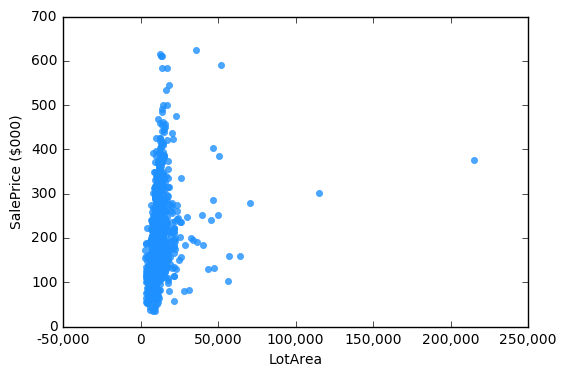

In [34]:
sc = sns.regplot(x="LotArea", y="SalePrice", 
                 data=train_miss3, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="SalePrice ($000)")
plt.show()

Clear outliers are observed.

**TotalBsmtSF**

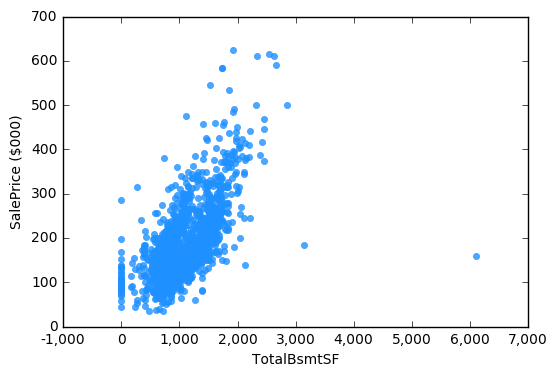

In [35]:
sc = sns.regplot(x="TotalBsmtSF", y="SalePrice", 
                 data=train_miss3, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="SalePrice ($000)", xlabel="TotalBsmtSF")
plt.show()

Additional outliers 

In [36]:
# Index value of the outliers for sq footage and lot area
outliers = train_miss3.sort_values(by = 'TotalBsmtSF', ascending = False).index[:2].tolist()
outliers.extend([train_miss3['LotArea'].idxmax()])
outliers

[1299, 2050, 1192]

In [37]:
# Index value of the maximums for the columns that are not majority zeroes
edafVars = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage']
max_index = pd.DataFrame(train_miss3[edafVars].idxmax())
max_index.columns = ['Index of Maximum']
max_index

,Index of Maximum
LotArea,1192
GrLivArea,1299
TotalBsmtSF,1299
LotFrontage,1299


In [38]:
# Remove the top two outliers from the TotalBsmtSF analysis
train_miss3.drop(outliers, axis=0, inplace=True)

**Lot Area**

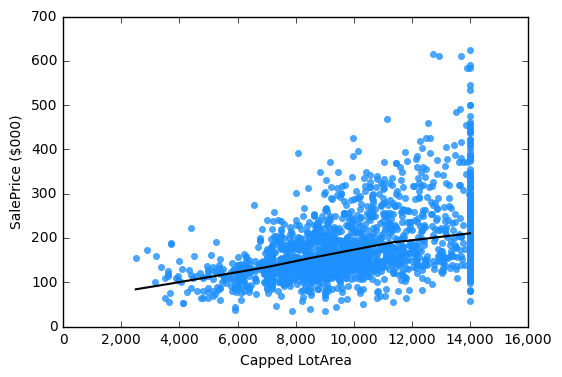

In [39]:
# Cap lot area
def cap_LA(row):
    if row['LotArea'] >= 14000:
        return 14000
    else:
        return row['LotArea']
    
train_miss3['LotArea_cap'] = train_miss3.apply(cap_LA, axis=1)
test_miss3['LotArea_cap'] = test_miss3.apply(cap_LA, axis=1)

sc = sns.regplot(x="LotArea_cap", y="SalePrice", 
                 data=train_miss3, lowess=True, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])

sc.set(ylabel="SalePrice ($000)", xlabel="Capped LotArea")
plt.show()

**GrLivArea**

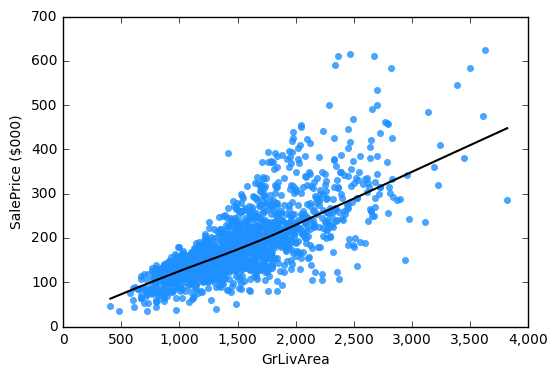

In [40]:
sc = sns.regplot(x="GrLivArea", y="SalePrice", 
                 data=train_miss3, lowess=True, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])

sc.set(ylabel="SalePrice ($000)")
plt.show()

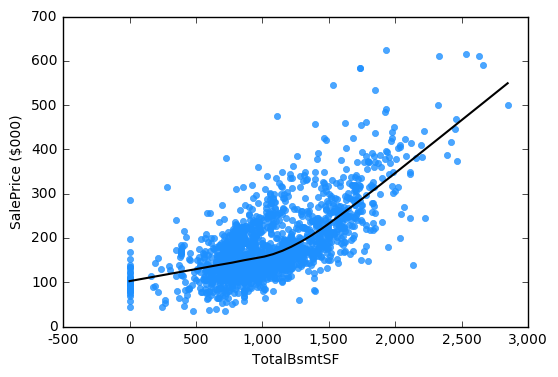

In [41]:
sc = sns.regplot(x="TotalBsmtSF", y="SalePrice", 
                 data=train_miss3, lowess=True, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])

sc.set(ylabel="SalePrice ($000)")
plt.show()

Number of zeroes and resulting non-linear relationship result in excluding this variable.

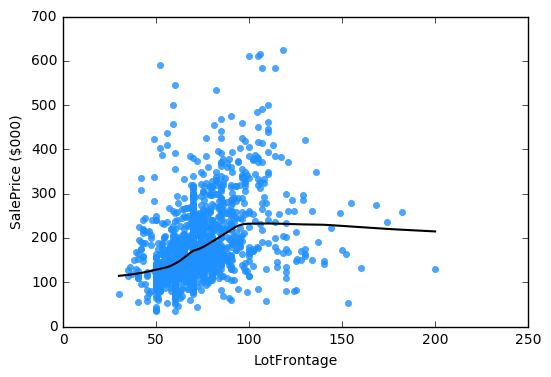

In [42]:
sc = sns.regplot(x="LotFrontage", y="SalePrice", 
                 data=train_miss3, lowess=True, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])

sc.set(ylabel="SalePrice ($000)")
plt.show()

Lack of a strong relationship with **SalePrice** result in not including this variable.

The final variables are included in a list. For **OverallQual** both the numeric and categorical versions are included.

In [43]:
# Final vars for use in model
finalVars = ['YearRemodel', 'GarageCars_grp', 'KitchenQual_grp',
             'Neighborhood_grp', 'BedroomAbvGr_grp', 'LotArea_cap',
             'GrLivArea', 'OverallQual_grp', 'OverallQual', 'SalePrice']

## Build Models

### Model 1 - Simple

In [44]:
# Split target and predictors into separate dataframes
X = train_miss3[finalVars[:-1]]
y = train_miss3['SalePrice']

# Loop through variables for best model by AIC
comb={}
for column in itertools.combinations(X.columns, 1):
    X_sub = X[list(column)]
    X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
    regr = sm.OLS(y.values, X_dum.values).fit()
    comb[column[0]] = [regr.rsquared, regr.rsquared_adj, regr.aic]
leaders = pd.DataFrame.from_dict(comb, orient='index').reset_index()
leaders.columns = ['Var', 'R-Squared', 'Adj R-Squared', 'AIC']
leaders.sort_values(['AIC'], inplace=True)
display(leaders.style.format({'R-Squared': '{:,.4f}'.format,
                              'Adj R-Squared': '{:,.4f}'.format, 
                              'AIC': '{:,.2f}'.format}))

For a single-variable model, **OverallQual_grp** used in regression results in the best model. 

Diagnostic plots for best performing model.

**Produces a large amount of output so collapse the output cell of the notebook.**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     603.3
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        06:27:15   Log-Likelihood:                -20405.
No. Observations:                1695   AIC:                         4.083e+04
Df Residuals:                    1686   BIC:                         4.088e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.645e+04   1.37e+04      4.127      0.000    2.96e+04    8.33e+04
x1          2.276e+04    1.6e+04      1.419      0.156   -8694.716    5.42e+04
x2          5.125e+04   1.41e+04      3.631      0.000    2.36e+04    7.89e+04
x3          7.944e+04   1.38e+04      5.756      0.000    5.24e+04    1.07e+05
x4          1.075e+05   1.38e+04      7.772      0.000    8.04e+04    1.35e+05
x5          1.508e+05   1.39e+04     10.883      0.000    1.24e+05    1.78e+05
x6          2.229e+05    1.4e+04     15.949      0.000    1.95e+05     2.5e+05
x7          3.238e+05   1.47e+04     22.002      0.000    2.95e+05    3.53e+05
x8          4.098e+05   1.69e+04     24.226      0.000    3.77e+05    4.43e+05
==============================================================================
Omnibus:                      254.395   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1057.085
Skew:                           0.667   Prob(JB):                    2.86e-230
Kurtosis:                       6.631   Cond. No.                         45.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

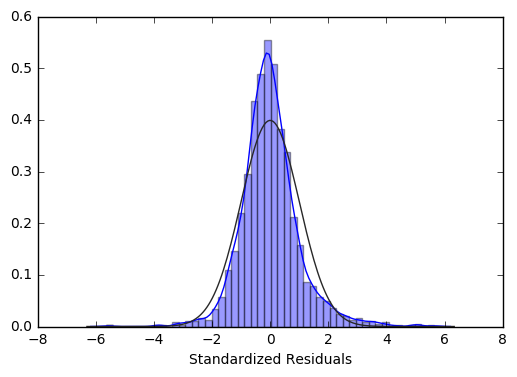

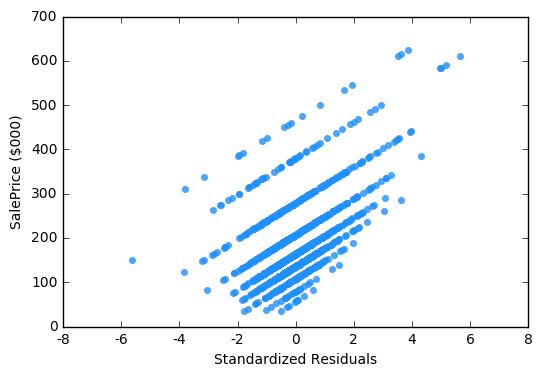

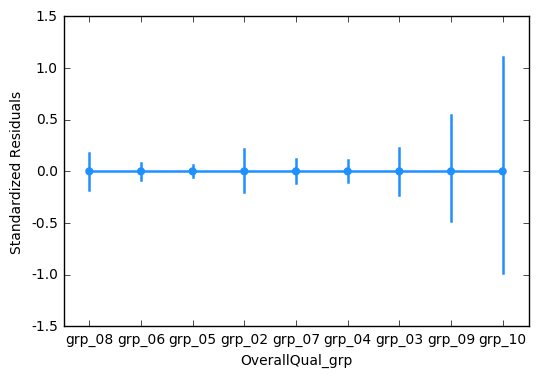

In [45]:
comb = {}
X_sub = train_miss3[['OverallQual_grp']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
regr = sm.OLS(y.values, X_dum.values).fit()
comb["OverallQual_grp"] = [regr.rsquared, regr.rsquared_adj, regr.aic]
model3 = pd.DataFrame.from_dict(comb, orient='index').reset_index()
model3.columns = ['Vars', 'R-Squared', 'Adj R-Squared', 'AIC']
model3.sort_values(['AIC'], inplace=True)
display(model3.style.format({'R-Squared': '{:,.4f}'.format,
                              'Adj R-Squared': '{:,.4f}'.format, 
                              'AIC': '{:,.2f}'.format}))
display(regr.summary())
df = train_miss3.copy()
df['Std Resid'] = preprocessing.scale(pd.DataFrame(y.values - regr.fittedvalues))
# Residual histogram
hplot1 = sns.distplot(df['Std Resid'], fit=scipy.stats.norm)
hplot1.set(xlabel='Standardized Residuals')
plt.show()
# Residual Scatter Plot
sc = sns.regplot(x="Std Resid", y="SalePrice", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="SalePrice ($000)", xlabel="Standardized Residuals")
plt.show()
# Residuals by OverallQual_grp
sc = sns.pointplot(x="OverallQual_grp", y="Std Resid", 
                 data=df,
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.1f}'.format(x) for x in yticks])
sc.set(ylabel="Standardized Residuals")
plt.show()

### Model 2 - Two-Variable Model

In [46]:
# Loop through two-way combinations for best model by AIC
comb={}
for column in itertools.combinations(X.columns, 2):
    X_sub = X[list(column)]
    X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
    regr = sm.OLS(y.values, X_dum.values).fit()
    comb[column] = [regr.rsquared, regr.rsquared_adj, regr.aic]
leaders = pd.DataFrame.from_dict(comb, orient='index').reset_index()
leaders.columns = ['Vars', 'R-Squared', 'Adj R-Squared', 'AIC']
leaders.sort_values(['AIC'], inplace=True)
display(leaders.head(10).style.format({'R-Squared': '{:,.4f}'.format,
                              'Adj R-Squared': '{:,.4f}'.format, 
                              'AIC': '{:,.2f}'.format}))

For a two-variable model, **GrLivArea** and **OverallQual_grp** result in the best model.

Diagnostic plots for best performing model.

**Produces a large amount of output so collapse the output cell of the notebook.**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     856.0
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        06:27:17   Log-Likelihood:                -20095.
No. Observations:                1695   AIC:                         4.021e+04
Df Residuals:                    1685   BIC:                         4.026e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7488.2381   1.15e+04      0.649      0.516   -1.51e+04    3.01e+04
x1            60.8711      2.229     27.308      0.000      56.499      65.243
x2          1.027e+04   1.34e+04      0.768      0.442   -1.59e+04    3.65e+04
x3          3.112e+04   1.18e+04      2.642      0.008    8021.679    5.42e+04
x4          5.478e+04   1.15e+04      4.751      0.000    3.22e+04    7.74e+04
x5          6.802e+04   1.16e+04      5.860      0.000    4.53e+04    9.08e+04
x6          9.567e+04   1.17e+04      8.165      0.000    7.27e+04    1.19e+05
x7          1.514e+05   1.19e+04     12.694      0.000    1.28e+05    1.75e+05
x8          2.413e+05   1.26e+04     19.111      0.000    2.17e+05    2.66e+05
x9          3.085e+05   1.46e+04     21.178      0.000     2.8e+05    3.37e+05
==============================================================================
Omnibus:                      244.166   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3056.362
Skew:                           0.170   Prob(JB):                         0.00
Kurtosis:                       9.570   Cond. No.                     6.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

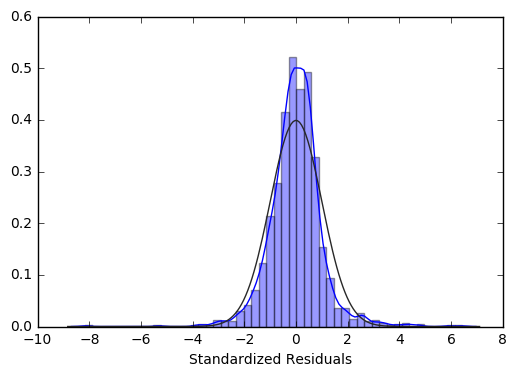

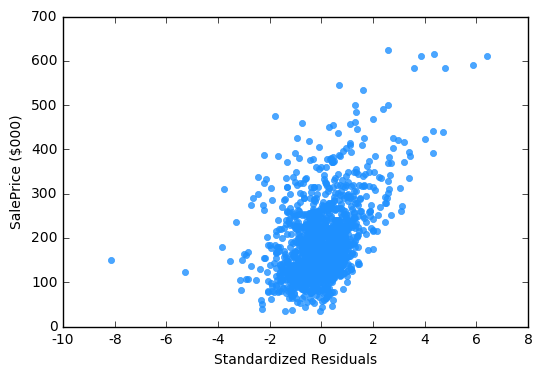

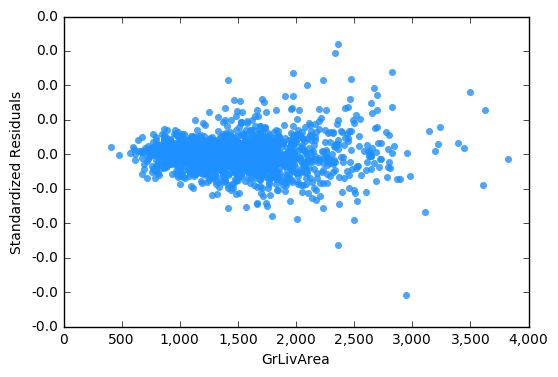

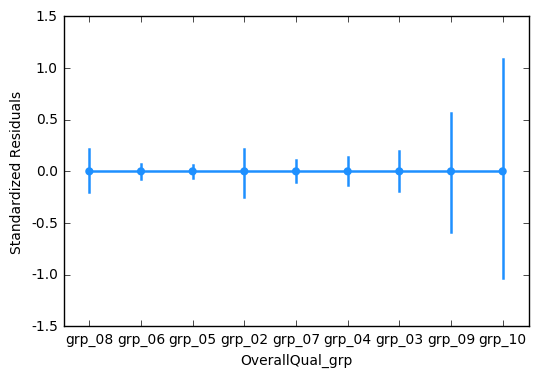

In [47]:
# Fit Statistics
X_sub = X[['GrLivArea', 'OverallQual_grp']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
regr = sm.OLS(y.values, X_dum.values).fit()
display(regr.summary())
# Residual histogram
df = train_miss3.copy()
df['Std Resid'] = preprocessing.scale(pd.DataFrame(y.values - regr.fittedvalues))
hplot1 = sns.distplot(df['Std Resid'], fit=scipy.stats.norm)
hplot1.set(xlabel='Standardized Residuals')
plt.show()
# Residual Scatter Plot
sc = sns.regplot(x="Std Resid", y="SalePrice", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="SalePrice ($000)", xlabel="Standardized Residuals")
plt.show()
# Residuals by GrLivArea
sc = sns.regplot(x="GrLivArea", y="Std Resid", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.1f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="Standardized Residuals")
plt.show()
# Residuals by OverallQual_grp
sc = sns.pointplot(x="OverallQual_grp", y="Std Resid", 
                 data=df, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.1f}'.format(x) for x in yticks])
sc.set(ylabel="Standardized Residuals")
plt.show()

### Model 3 - Two-Variable Model with Transformations

Diagnostic plots for **Model 2** with variable transformations.

**Produces a large amount of output so collapse the output cell of the notebook.**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     863.7
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        06:27:19   Log-Likelihood:                -20170.
No. Observations:                1695   AIC:                         4.036e+04
Df Residuals:                    1686   BIC:                         4.041e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.273e+05   2.64e+04    -19.991      0.000   -5.79e+05   -4.76e+05
x1          8.832e+04   3560.857     24.802      0.000    8.13e+04    9.53e+04
x2           499.7340    1.4e+04      0.036      0.972   -2.69e+04    2.79e+04
x3          1.719e+04   1.24e+04      1.391      0.164   -7052.963    4.14e+04
x4          3.937e+04   1.21e+04      3.248      0.001    1.56e+04    6.31e+04
x5          5.084e+04   1.23e+04      4.150      0.000    2.68e+04    7.49e+04
x6          7.907e+04   1.24e+04      6.374      0.000    5.47e+04    1.03e+05
x7          1.384e+05   1.26e+04     10.954      0.000    1.14e+05    1.63e+05
x8          2.483e+05   1.32e+04     18.840      0.000    2.22e+05    2.74e+05
==============================================================================
Omnibus:                      259.827   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2762.767
Skew:                           0.348   Prob(JB):                         0.00
Kurtosis:                       9.216   Cond. No.                         288.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

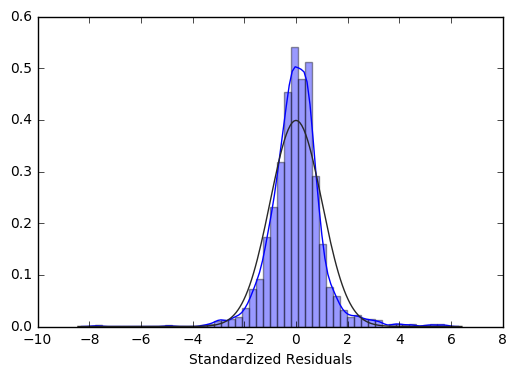

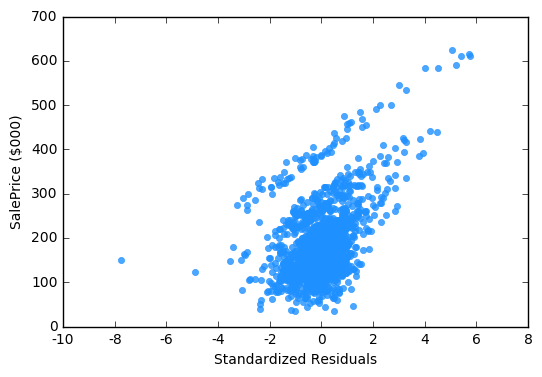

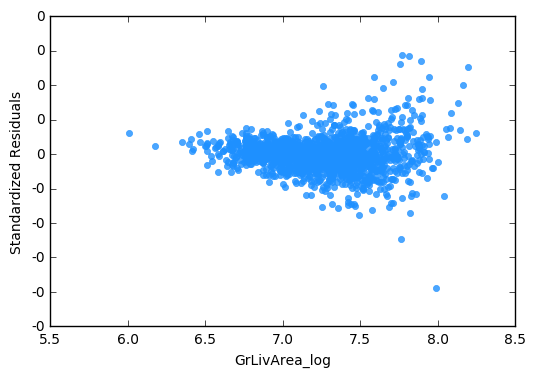

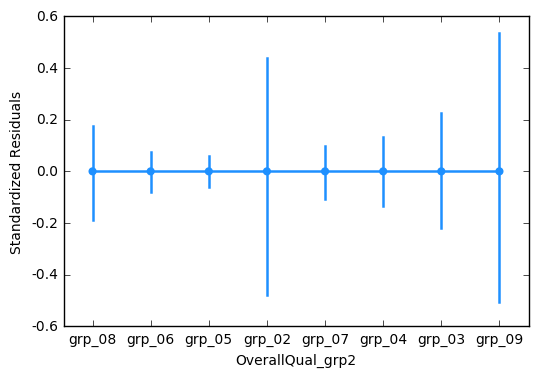

In [48]:
# Create new transformed variables
train_miss3['GrLivArea_log'] = np.log(train_miss3['GrLivArea'])
test_miss3['GrLivArea_log'] = np.log(train_miss3['GrLivArea'])

def grp_OQ2(row):
    if row['OverallQual'] == 1:
        return "grp_02"
    elif row['OverallQual'] == 10:
        return "grp_09"
    else:
        return "grp_" + str(row['OverallQual']).zfill(2) 

train_miss3['OverallQual_grp2'] = train_miss3.apply(grp_OQ2, axis=1)
test_miss3['OverallQual_grp2'] = test_miss3.apply(grp_OQ2, axis=1)

comb = {}
X_sub = train_miss3[['GrLivArea_log', 'OverallQual_grp2']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
regr = sm.OLS(y.values, X_dum.values).fit()
comb["('GrLivArea_log', 'OverallQual_grp2')"] = [regr.rsquared, regr.rsquared_adj, regr.aic]
model3 = pd.DataFrame.from_dict(comb, orient='index').reset_index()
model3.columns = ['Vars', 'R-Squared', 'Adj R-Squared', 'AIC']
model3.sort_values(['AIC'], inplace=True)
display(model3.style.format({'R-Squared': '{:,.4f}'.format,
                              'Adj R-Squared': '{:,.4f}'.format, 
                              'AIC': '{:,.2f}'.format}))
display(regr.summary())
df = train_miss3.copy()
df['Std Resid'] = preprocessing.scale(pd.DataFrame(y.values - regr.fittedvalues))
# Residual histogram
hplot1 = sns.distplot(df['Std Resid'], fit=scipy.stats.norm)
hplot1.set(xlabel='Standardized Residuals')
plt.show()
# Residual Scatter Plot
sc = sns.regplot(x="Std Resid", y="SalePrice", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="SalePrice ($000)", xlabel="Standardized Residuals")
plt.show()
# Residuals by GrLivArea
sc = sns.regplot(x="GrLivArea_log", y="Std Resid", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.1f}'.format(x) for x in xticks])
sc.set(ylabel="Standardized Residuals")
plt.show()
# Residuals by OverallQual_grp2
sc = sns.pointplot(x="OverallQual_grp2", y="Std Resid", 
                 data=df,
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.1f}'.format(x) for x in yticks])
sc.set(ylabel="Standardized Residuals")
plt.show()

The adjustments result in greater violation of assumptions, so the third model is not recommended. 

### Model 4 - Two-Variable Model with Target Encoding for Neighborhood

In [49]:
final_nomVars = ['Neighborhood_grp']

def target_encode(df):
    encd = df.copy()
    encd.reset_index(inplace=True)
    for columns in final_nomVars:
        woe = train_miss3[[columns, 'SalePrice']].groupby(columns).agg([np.mean])
        woe.columns = woe.columns.droplevel()
        woe.columns = [columns+"_enc"]
        encd = encd.merge(woe.reset_index(), how='left')
        encd[columns+"_enc"].fillna(encd[columns+"_enc"].mode()[0], inplace=True)
    encd.set_index('index', inplace=True)
    return encd

train_enc = target_encode(train_miss3)
test_enc = target_encode(test_miss3)

Diagnostic plots for **Model 4**.

**Produces a large amount of output so collapse the output cell of the notebook.**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     729.2
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        06:27:22   Log-Likelihood:                -20204.
No. Observations:                1695   AIC:                         4.043e+04
Df Residuals:                    1685   BIC:                         4.048e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2464.6908   1.24e+04      0.198      0.843   -2.19e+04    2.68e+04
x1             0.4511      0.021     21.221      0.000       0.409       0.493
x2          2.191e+04   1.43e+04      1.537      0.124   -6045.735    4.99e+04
x3          4.554e+04   1.25e+04      3.631      0.000    2.09e+04    7.01e+04
x4          6.677e+04   1.23e+04      5.438      0.000    4.27e+04    9.09e+04
x5          8.668e+04   1.23e+04      7.031      0.000    6.25e+04    1.11e+05
x6          1.146e+05   1.24e+04      9.220      0.000    9.02e+04    1.39e+05
x7          1.577e+05   1.28e+04     12.329      0.000    1.33e+05    1.83e+05
x8          2.351e+05   1.37e+04     17.121      0.000    2.08e+05    2.62e+05
x9          3.166e+05   1.57e+04     20.219      0.000    2.86e+05    3.47e+05
==============================================================================
Omnibus:                      341.425   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1636.331
Skew:                           0.870   Prob(JB):                         0.00
Kurtosis:                       7.488   Cond. No.                     8.07e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

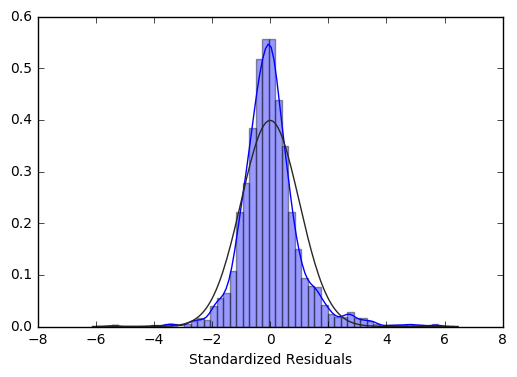

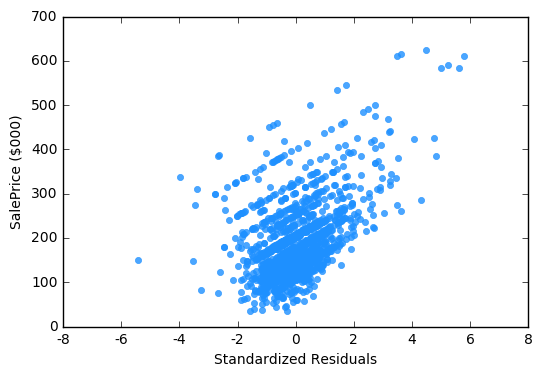

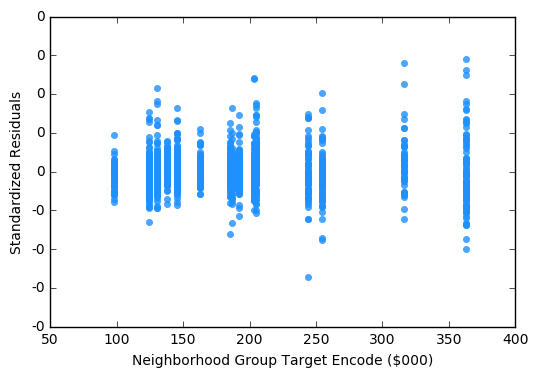

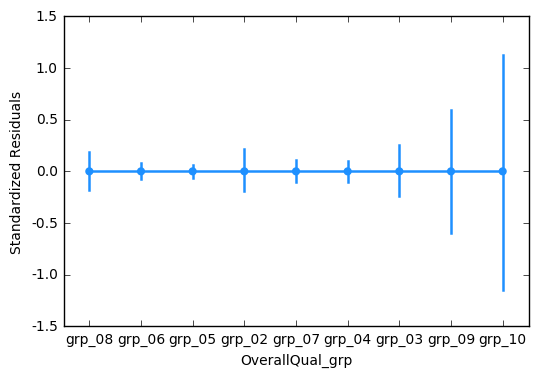

In [50]:
comb = {}
X_sub = train_enc[['OverallQual_grp', 'Neighborhood_grp_enc']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
regr = sm.OLS(y.values, X_dum.values).fit()
comb["('OverallQual_grp', 'Neighborhood_grp_enc')"] = [regr.rsquared, regr.rsquared_adj, regr.aic]
model3 = pd.DataFrame.from_dict(comb, orient='index').reset_index()
model3.columns = ['Vars', 'R-Squared', 'Adj R-Squared', 'AIC']
model3.sort_values(['AIC'], inplace=True)
display(model3.style.format({'R-Squared': '{:,.4f}'.format,
                              'Adj R-Squared': '{:,.4f}'.format, 
                              'AIC': '{:,.2f}'.format}))
display(regr.summary())
df = train_enc.copy()
df['Std Resid'] = preprocessing.scale(pd.DataFrame(y.values - regr.fittedvalues))
# Residual histogram
hplot1 = sns.distplot(df['Std Resid'], fit=scipy.stats.norm)
hplot1.set(xlabel='Standardized Residuals')
plt.show()
# Residual Scatter Plot
sc = sns.regplot(x="Std Resid", y="SalePrice", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
sc.set(ylabel="SalePrice ($000)", xlabel="Standardized Residuals")
plt.show()
# Residuals by Neighborhood encoded
sc = sns.regplot(x="Neighborhood_grp_enc", y="Std Resid", 
                 data=df, fit_reg=False, 
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
xticks = sc.get_xticks()
sc.set_xticklabels(['{:,.0f}'.format(x/1000) for x in xticks])
sc.set(ylabel="Standardized Residuals", xlabel="Neighborhood Group Target Encode ($000)")
plt.show()
# Residuals by OverallQual_grp
sc = sns.pointplot(x="OverallQual_grp", y="Std Resid", 
                 data=df,
                 color="dodgerblue", line_kws={'color': 'black'})
yticks = sc.get_yticks()
sc.set_yticklabels(['{:,.1f}'.format(x) for x in yticks])
sc.set(ylabel="Standardized Residuals")
plt.show()

## Select Final Model

Model 2 is selected as described in the report.

## Final Model Equations

Output coefficients

In [51]:
X_sub = train_miss3[['GrLivArea', 'OverallQual_grp']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
regr = sm.OLS(y.values, X_dum.values).fit()
final_coef = pd.DataFrame({'Variable': X_dum.columns.tolist(), 
                                 'Coefficient': regr.params.tolist()})
display(final_coef[['Variable', 'Coefficient']].style.format({'Coefficient': '{:,.2f}'.format}))

## Score Test Set

In [52]:
# Score model 2 on test set
test_sub = test_miss3[['GrLivArea', 'OverallQual_grp']]
test_dum = sm.add_constant(pd.get_dummies(test_sub, drop_first=True))
predictions = pd.DataFrame(regr.predict(test_dum))
# Output in format needed for Kaggle
predictions.columns = ['p_saleprice']
predictions.to_csv('assignment1_alan_kessler.csv')

## Bonus Gamma GLM

In [53]:
# Fit Gamma GLM for Model 2 variables
X_sub = train_enc[['OverallQual_grp', 'GrLivArea']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
gamma_model = sm.GLM(y.values, X_dum.values, family=sm.families.Gamma(sm.genmod.families.links.log)).fit()

In [54]:
# Plot a summary
gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1695
Model:                            GLM   Df Residuals:                     1685
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                 0.0299990385158
Method:                          IRLS   Log-Likelihood:                -19880.
Date:                Fri, 19 Jan 2018   Deviance:                       54.050
Time:                        06:27:24   Pearson chi2:                     50.5
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6740      0.058    182.634      0.000      10.559      10.789
x1             0.0003   1.13e-05     27.893      0.000       0.000       0.000
x2             0.2709      0.068      4.000      0.000       0.138       0.404
x3             0.5511      0.060      9.232      0.000       0.434       0.668
x4             0.7591      0.058     12.991      0.000       0.645       0.874
x5             0.8657      0.059     14.716      0.000       0.750       0.981
x6             1.0218      0.059     17.208      0.000       0.905       1.138
x7             1.2373      0.060     20.465      0.000       1.119       1.356
x8             1.4877      0.064     23.250      0.000       1.362       1.613
x9             1.5934      0.074     21.581      0.000       1.449       1.738
==============================================================================
"""

In [55]:
# Print AIC
gamma_model.aic

39780.65519232404